# Transformer模型

Transformer的本质上是一个Encoder-Decoder的结构
可以如下图表示
![Transformer](imgs/tf2.png)

本笔记对Transformer模型记录采用流式结构，也就是说，我将从一个样本数据的输入到输出的过程进行模型分析

## Input and Output Embedding

### Word Embedding

词嵌入自13年的word2vec出来之后，就非常的火爆。自然语言模型就再也没离开过它。它将序列中的每一个token使用一个分布式的向量表示出来，这个向量的维度通常不是太高(1000以下)

假设经过Embedding后的输入变成了$X_{embedding}$

### Positional Encoding

Transformer模型中没有**迭代**处理所有的字或者词，所以我们需要提供每个字的位置信息给transformer，才能识别出语言中的顺序关系。

在Google的论文中，使用sine以及cosine两个函数的线性变换，提供给模型输出序列中的顺序信息

$$
\begin{aligned} 
&PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}})\\ 
&PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}})
\end{aligned}  
$$
对于一个sequence中不同pos的字，它的字向量相同维度的positional encoding呈现周期性变化(即PE中的每一列)，这个周期随维度的增加而增加，上述函数的周期在$2\pi$到$10000 \times 2\pi$


PE是一个二维的矩阵，这个矩阵的大小与$X_{embedding}$的大小一致。
使用方式是
$$X{embedding} = X_{embedding} + PE$$

<br>
下面构建一个100个字，嵌入向量16维的PE矩阵

In [18]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


def get_positional_encoding(max_seq_len, embed_dim):
    '''
    初始化一个positional encoding
    max_seq_len: 最大序列长度
    embed_dim:   字嵌入的维度
    生成一个shape为(max_seq_len, embed_dim)的二维numpy矩阵
    该矩阵的奇数列使用sine函数处理，偶数列使用cosine函数处理
    '''
    positional_encoding = np.array([
        [pos /np.power(10000, (i if i%2==0 else (i - 1))/embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)
    ])
    positional_encoding[:, 0::2] = np.sin(positional_encoding[:, 0::2])
    positional_encoding[:, 1::2] = np.cos(positional_encoding[:, 1::2])
    return positional_encoding

Text(69.0, 0.5, 'sequence length')

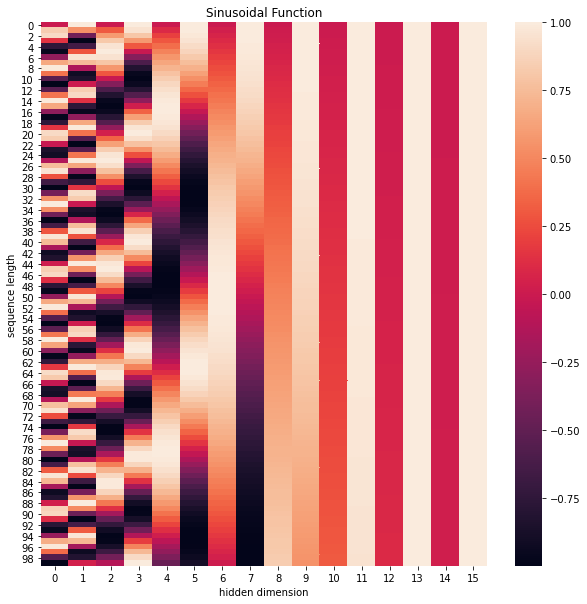

In [19]:
positional_encoding = get_positional_encoding(100, 16)
plt.figure(figsize=(10, 10))
sns.heatmap(positional_encoding)
plt.title("Sinusoidal Function")
plt.xlabel("hidden dimension")
plt.ylabel("sequence length")

Text(0, 0.5, 'Period of Positional Encoding')

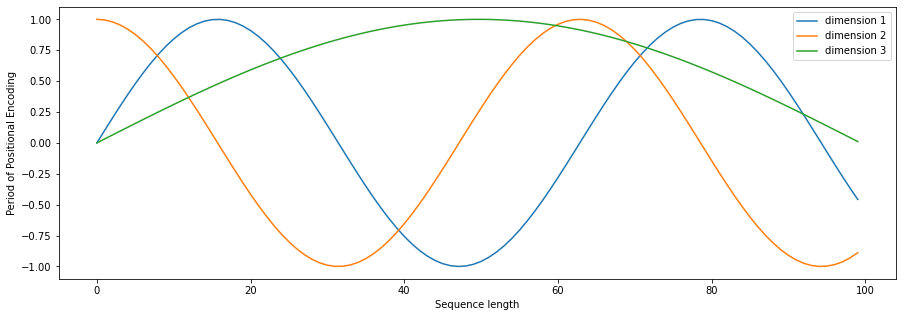

In [21]:
plt.figure(figsize=(15, 5))
plt.plot(positional_encoding[:, 4], label="dimension 1")
plt.plot(positional_encoding[:, 5], label="dimension 2")
plt.plot(positional_encoding[:, 6], label="dimension 3")
plt.legend()
plt.xlabel("Sequence length")
plt.ylabel("Period of Positional Encoding")

In [13]:
# 输出positional encoding矩阵的一部分，查看其数值
positional_encoding[:4, :4]

array([[ 0.        ,  1.        ,  0.        ,  1.        ],
       [ 0.97855249,  0.84600911,  0.53316844,  0.98423023],
       [-0.40315897,  0.43146283,  0.90213071,  0.93741831],
       [-0.81245292, -0.11596614,  0.99325317,  0.86104065]])

## Encoder详解
在Google的论文原文中，Encoder部分是6个重复结构组成的线性堆叠而成。

重复单元为multi-head Attention Mechanism和[前向神经网络](fnn.ipynb)层组成，本笔记将不再叙述前向神经网络

### Multi-head Attention Mechanism

假如现在有一些句子$X$,$X$的维度是[batch_size, sequence_length],首先我们在字向量里面查找相应的嵌入，然后与位置嵌入元素相加，得到最终的embedding,其维度是[batch_size, sequence_length, embedding_dimension]
<br>
$$
\begin{aligned}
& X \in R^{batch\_size \times sequence\_length}\\
& X_{embedding} = EmbeddingLookup(X) + PositionalEncoding\\
& X_{embedding}\in R^{batch\_size \times sequence\_length \times embed.dim}
\end{aligned}
$$

为了学到多重含义的表达，我们对输入的$X_{embedding}$做线性映射，也就是分配三个权重$W_Q, W_K, W_V \in R^{embed.dim \times embed.dim}$,线性映射之后，形成三个矩阵，为Q, K, V和线性变换之前的维度一致

$$Q = Linear(X_{embedding}) = X_{embedding}W_Q$$
$$K = Linear(X_{embedding}) = X_{embedding}W_K$$
$$V = Linear(X_{embedding}) = X_{embedding}W_V$$

Transformer模型中的Attention被称为self-attention, 其计算的大概示意图如下

![](./imgs/tf1.png)

Q,K,V形状相同，且都存储了sequence的信息。其中Q又称为query，它的作用是每一次都拿一个word embedding去跟同一sequence种其他word embedding计算相似度。由于每一个word embedding都是$d_model$维的向量，所以word embedding之间的相似度可以简单地用向量乘积表示。

对于sequence中第i个word的embedding $v_i$,它的Attention值为
$$Attention(Q_i, K, V) = softmax\big(v_i \cdot (v_1^T, v_2^T, \dots,v_n^T)\big) \cdot \begin{bmatrix}
v_1 \\
v_2 \\
\vdots \\
v_n \\
\end{bmatrix}
$$

知道单个的Attention怎么计算之后，多头Attention就很简单了。
<br>首先定义一个超参***h***,***h***代表head的个数，值得注意的是，需要满足一个公式$embedding\_dimension\ mod\ h == 0$,这是由于我们需要将embedding_dimension分成***h***份。

那么，整个Q矩阵的Attention值计算公式如下
$$
Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$
此处需要除以$\sqrt{d_k}$,原因如下，假设Q,K中的元素均独立同分布与标准正态(mean 0 and variance 1)，当Q，K做点积操作后，结果矩阵中的每一个元素的服从mean为0，variance为$dimension_K$的正态分布。故除以$\sqrt{d_k}$后，结果中每一个元素又独立同分布与标准正态。

近期，对为什么需要除以$d_k$有了更好的[解释](https://mp.weixin.qq.com/s/X9WnScWRyM7hfikcuLhNOg)

知道单个的Attention怎么计算之后，多头Attention就很简单了。
<br>首先定义一个超参***h***,***h***代表head的个数，值得注意的是，需要满足一个公式$embedding\_dimension\ mod\ h == 0$,这是由于我们需要将embedding_dimension分成***h***份。

经过分割以后，Q,K,V的维度为$[\text{batch_size, sequence_length, h, embedding_dimension/h]}$为了方便后续的计算，我们将Q，K，V转置一下，维度变成$\text{[batch_size, h, sequence_length, embedding_dimension/h]}$
<br>
多头实际上是将Q，K，V在列方向平均分成了***h***份，然后分别进行scaled dot-preduct attention计算，然后将所有头计算的Attention拼接起来，可以得到一个形状为$\text{[batch_size, sequence_length,embedding_dimension]}$的结果张量。这个张量就是Transformer模型中多头注意力机制的输出。

值得注意的是，我们在计算self-attention的过程中，通常使用mini-batch，也就是一次计算多句话。不同的句子可能长度不同，对于长度不够的句子，就需要padding操作，通常是padding 0。0在softmax归一化操作的时候，该位置会计算出一个大于0的值。通常是在padding的无效区域内加上一个无穷小的偏置，这样经过softmax归一化后的值仍然为0。

### Layer Normalization和残差连接

#### 残差连接

经过multi-head attention运算之后，得到V，也就是Attention(Q,K,V)，我们对它进行一下转置，使其和$X_{embedding}$的维度一样，也就是$\text{[batch_size, sequence_length, embedding_dimension]}$，然后把他们直接接加起来，因为他们的维度一样

$$X_{embedding} + Attention(Q,K,V)$$
在之后的计算里，每经过一个模块的运算，都要把运算之前的值和运算后的值相加，从而得到残差连接，训练的时候，可以使梯度直接走捷径反传到最初始层
$$X + SubLayer(X)$$

## Layer Normalization
Layer Normalization的作用是把神经网络中隐藏层归一为标准正态分布，也就是独立同分布

上式中以矩阵的行(row)为单位求均值
$$\mu_i = \frac{1}{m}\sum_{j = 1}^m x_{ij}$$

上式中以矩阵的行(row)为单位求方差
$$\sigma_i^2 = \frac{1}{m}\sum_{j = 1}^m (x_{ij} -\mu_i)^2$$

然后用**每一行**的**每一个元素**减去这行的**均值**，再除以这行的标准差，从而得到归一化后的数值，使用$\varepsilon$是为了防止除0，

$$LayerNorm(X) = \alpha \odot \frac{x_{i} - \mu_i}{\sqrt{\sigma_i^2 + \varepsilon}} + \beta$$

引入$\alpha$,$\beta$(维度为词嵌入的维度)是为了弥补归一化过程中损失掉的信息，$\odot$表示矩阵对应位置的元素相乘。

### Encoder整体架构

经过上述三个部分的介绍，我们就可以实现Transformer model的encoder部分。
<br>
下面使用公式的方式，表达出一个transforemr encoder block的计算过程

1. word embedding and positional encoding
$$X = EmbeddingLookup(X) + PositionalEncoding \tag{1}$$
2. self-attention mechanism
$$
\begin{aligned}
&Q = Linear(X) = XW_Q\\
&K = Linear(X) = XW_K\\
&V = Linear(X) = XW_V\\
\end{aligned}
\tag{2}
$$
$$X_{attention} = SelfAttention(Q,K,V) \tag{3}$$
3.残差连接与Layer Normalization
$$X_{attention} = X + X_{attention} \tag{4}$$

$$X_{attention} = LayerNorm(X_{attention}) \tag{5}
$$
4. feed forward
$$X_{hidden} = Active(Linear(Linear(X_{attention})) \tag{6}$$
5. repeat step 3
$$
\begin{aligned}
&X_{hidden} = X_{attention} + X_{hidden}\\
&X_{hidden} = LayerNorm(X_{hidden})
\end{aligned}
$$

最终一个encoder block的输出形状为
$$X \in R^{batch\_size\ \times\ seq\_len\ \times\ embed.dim}$$

## Decoder与Encoder的差异
从笔记开头的Transformer的结构图可以看出，Encoder和Decoder仅有如下差别。

1. Masked Multi-Headed Attention
  mask的目的是为了防止模型看见未来的信息。在进行attention操作中，$QK^T$得到的是一个长宽为seq_len的方阵，是一个如下图所示，黄色部分为1的下三角矩阵。这样的前面的词就不能看见后面的词了。

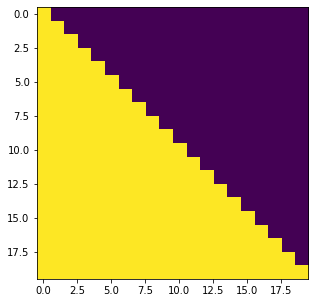

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return (subsequent_mask) == 0

plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
plt.show()

2. Encoder-Decoder Multi-Headed Attention
  这一层的query矩阵是上一个masked multi-headed attention的输出，而key以及value则是Encoder的输出。

## Transformer测试的过程

假设我们有一个已经训练好的网络, 我们用“我爱中国”来生成“I Love China”， 步骤如下：

1. 将“我爱中国”输入到Transformer的Encoer中，得到其输出。
2. 给Decoder输入Encoder的输出和一个特殊的开始符号 </s>。Decoder将产生预测，在我们的例子中应该是 ”I”。
3. 给Decoder输入Encoder的输出和 “</s>I”，在这一步Decoder应该产生预测 “Love”。
4. 给Decoder输入Encoder的输出和 “</s>I Love”，在这一步Decoder应该产生预测 “China”。
5. 给Decoder输入Encoder的输出和 “</s>I Love China”, Decoder应该生成句子结尾的标记，Decoder 应该输出 ”</eos>”。

然后 Decoder 生成了 </eos>，翻译完成。